In [1]:
%matplotlib inline
import sparse_ternary_networks.Tools as T
import sparse_ternary_networks.loadLab as load
import numpy as np
import sparse_ternary_networks.MLSTC as MLSTC
import matplotlib.pyplot as plt
##
import torch
from torch import nn
from torch.autograd import Variable
import sparse_ternary_networks.PyTorcher_MLSTC as STNetTorcher
import RRQ.Tools as Tools

In [2]:
# Initializing the parameters:
m = 500       # dimension of the codes
k = 2         # number of non-zero elements of the STC at each stage.
L = 5        # number of layer units of the network.
N_train = 60000

In [3]:
# Torch hyper-params:
dtype = torch.FloatTensor
num_epoch = 10    
learning_rate = 1e-3  
num_batch = 100
weight_decay = 0

In [4]:
numRep = 1
MethodList = ['STNetRandom','STNetMLSTC','Random','MLSTC','STNetProcrustean','Procrustean']
for Method in MethodList:
    exec('dist_' + Method  + '_train = np.zeros((numRep,L+1))')
    exec('dist_' + Method  + '_test = np.zeros((numRep,L+1))')
    #
    exec('rate_' + Method  + ' = np.zeros((numRep,L+1))')

In [5]:
# mnist, fashion, cifar10 loading and normalization:
path = 'Data/mnist.npz'
# path = 'Data/cifar10.npz'
data = np.load(path)
if 'cifar10' in path:
    nchannel = 3
    Database = 'CIFAR10'
elif 'mnist' in path:
    nchannel = 1
    Database = 'MNIST'
elif 'fashion' in path:
    nchannel = 1
    Database = 'FASHION'
data = np.load(path)
imgs_train = np.divide(data['imgs_train'],255).astype(float)
imgs_test = np.divide(data['imgs_test'],255).astype(float)
# Y_train = data['Y_train'].reshape(1,-1)
# Y_test = data['Y_test'].reshape(1,-1)
# Normalization:
imgs_train -= np.mean(imgs_train)
imgs_test -= np.mean(imgs_test)
#
imgs_train /= np.std(imgs_train)
imgs_test /= np.std(imgs_test)
#imgs_resolution = (28,28,nchannel)
#
####################################################################################
# DCT?:
F_train = load.imgTensor2matrix_zigzagDCT(imgs_train,nchannel)
F_test = load.imgTensor2matrix_zigzagDCT(imgs_test,nchannel)
#F_train = imgs_train.reshape(-1,60000)
#F_test = imgs_test.reshape(-1,10000)
####################################################################################
## Whitening using sub-band PCA:
# numSB = 1
# F0_train,EigVecs,dim_means = STNet.SubbandPCA_whitner(F0_train,numSB)
# F0_test,_,_ = STNet.SubbandPCA_whitner(F0_test,numSB,EigVecs=EigVecs,dim_means=dim_means)
##
F_train = F_train[:,0:N_train]
n,N_train = F_train.shape
N_test = F_test.shape[1]
#
norm_train = np.divide(np.linalg.norm(F_train) ** 2, np.prod(F_train.shape))
norm_test = np.divide(np.linalg.norm(F_test) ** 2, np.prod(F_test.shape))
(n,_) = F_train.shape

In [6]:
# # MNIST loading, normalization and pre-processing:
# data = np.load('/home/sssohrab/Dropbox/Py/Data/mnist.npz')
# imgs_train = np.divide(data['imgs_train'],255).astype(float)
# imgs_test = np.divide(data['imgs_test'],255).astype(float)
# # Y_train = data['Y_train']
# # Y_test = data['Y_test']
# # Normalization:
# imgs_train -= np.mean(imgs_train)
# imgs_test -= np.mean(imgs_test)
# #
# imgs_train /= np.std(imgs_train)
# imgs_test /= np.std(imgs_test)
# nchannel = 1
# imgs_resolution = (28,28,nchannel)
# #
# ####################################################################################
# # DCT?:
# F_train = load.imgTensor2matrix_zigzagDCT(imgs_train,nchannel)
# F_test = load.imgTensor2matrix_zigzagDCT(imgs_test,nchannel)
# #F_train = imgs_train.reshape(-1,60000)
# #F_test = imgs_test.reshape(-1,10000)
# ############################
# F_train = F_train[:,0:N_train]
# n,N_train = F_train.shape
# N_test = F_test.shape[1]
# #
# norm_train = np.divide(np.linalg.norm(F_train) ** 2, np.prod(F_train.shape))
# norm_test = np.divide(np.linalg.norm(F_test) ** 2, np.prod(F_test.shape))

In [7]:
MethodList = ['STNetMLSTC','STNetRandom','STNetProcrustean']
#MethodList = ['STNetProcrustean']
for RepInd in range(numRep):
    print('.......................................  Repetition = ', RepInd + 1)
    # F_train, F_test = Tools.data_generator(n, N_train, N_test, 'AR1', SourceParam=Rho)
    #         norm_train = np.divide(np.linalg.norm(F_train) ** 2, np.prod(F_train.shape))
    #         norm_test = np.divide(np.linalg.norm(F_test) ** 2, np.prod(F_test.shape))
    for MethodInd, Method in enumerate(MethodList):
        print(' ############   ' + Method + '     A L G O R I T H M   ################')

        ###############################################
        # Pre-training:
        print('Pre-training:')
        if 'Random' in Method:
            Learner = 'Random'
        elif 'MLSTC' in Method:
            Learner = 'SuccessivePCA'
        elif 'Procrustean' in Method:
            Learner = 'ProcrusteanPCA'    
        ##    
        obj_pretrain = MLSTC.BaseLearner(k, L, m=m, Learner=Learner)
        _, _, _ = obj_pretrain.run(F_train)
        #
        if 'Random' in Method:
            exec ('dist_' + 'Random'  + '_train[RepInd,:] = obj_pretrain.distortion/norm_train')
            exec ('rate_' + 'Random'  + '[RepInd,:] = obj_pretrain.rate')

        elif 'MLSTC' in Method:
            exec ('dist_' + 'MLSTC'  + '_train[RepInd,:] = obj_pretrain.distortion/norm_train')
            exec ('rate_' + 'MLSTC'  + '[RepInd,:] = obj_pretrain.rate')

        elif 'Procrustean' in Method:
            exec ('dist_' + 'Procrustean'  + '_train[RepInd,:] = obj_pretrain.distortion/norm_train')
            exec ('rate_' + 'Procrustean'  + '[RepInd,:] = obj_pretrain.rate')
            
        # testing the pre-training:
        obj_pretest = MLSTC.fwdPass(obj_pretrain.params, k, ternaryProbMap=obj_pretrain.prob_z)
        _, _, _ = obj_pretest.run(F_test)
        if 'Random' in Method:
            exec ('dist_' + 'Random'  + '_test[RepInd,:] = obj_pretest.distortion/norm_test')
        elif 'MLSTC' in Method:
            exec ('dist_' + 'MLSTC'  + '_test[RepInd,:] = obj_pretest.distortion/norm_test')
        elif 'Procrustean' in Method:
            exec ('dist_' + 'Procrustean'  + '_test[RepInd,:] = obj_pretest.distortion/norm_test')    

        if 'STNet' not in Method:
            continue
        ###############################################
        # Fine-tuning:
        print('Fine-tuning: ')
        params = obj_pretrain.params
        #############################
        ## Training to fine-tune:
        obj_bp_train = STNetTorcher.fwdPass(params, k, nlinStrategy='KBest', beta_shape='scalar')
        optimizer = torch.optim.Adam(obj_bp_train.parameters(), betas= (0.9, 0.999),lr=learning_rate, weight_decay=weight_decay)
        #optimizer = torch.optim.SGD(obj_bp_train.parameters(), lr=learning_rate, momentum=0.1,dampening=0.1, weight_decay=weight_decay)
        # ################################
        F_torch = Variable(torch.from_numpy(np.copy(F_train)).type(dtype))
        counter = 0
        for epoch in range(num_epoch):
            rand_perm = np.random.permutation(N_train)
            batch_map = []
            for iter in range(num_batch):
                batch_map.append(
                    rand_perm[np.arange(iter * int(N_train / num_batch), (iter + 1) * int(N_train / num_batch))])
            for iter in range(num_batch):  # gives batch data
                batch_map_current = batch_map[iter]
                F_minibatch = F_torch[:, batch_map_current]
                F_chapeau = obj_bp_train.forward(F_minibatch)

                loss = (F_minibatch - F_chapeau).pow(2).mean()
                if iter % 10 == 0:
                    print('Epoch: ', epoch + 1, '| train loss: %.4f' % loss.data[0])
                # Zero gradients, perform a backward pass, and update the weights.
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                counter += 1
                # -------------
        for l in range(L):
            obj_bp_train.params[l]['A'] /= np.linalg.norm(obj_bp_train.params[l]['A'], axis=1).reshape(-1,
                                                                                                       1)

        # Re-adjusting beta:
        obj_beta = MLSTC.BaseLearner(k, L, m=m, Learner='SuccessivePCA')
        obj_beta.reRun_reweightUpdate(F_train, obj_bp_train.params)
        ###### Re-running on the final network on train set:
        obj_beta_train = MLSTC.fwdPass(obj_beta.params, k)
        _ = obj_beta_train.run(F_train)
        exec ('dist_' + Method  + '_train[RepInd,:] = obj_beta_train.distortion/norm_train')
        exec ('rate_' + Method  + '[RepInd,:] = obj_beta_train.rate')
        ###### Re-running on the final network on test set:
        obj_beta_test = MLSTC.fwdPass(obj_beta.params, k)
        _ = obj_beta_test.run(F_test)
        exec ('dist_' + Method  + '_test[RepInd,:] = obj_beta_test.distortion/norm_test')


.......................................  Repetition =  1
 ############   STNetMLSTC     A L G O R I T H M   ################
Pre-training:
 ################## Starting to learn network parameters:  ##################
layer-units:
** 1 **** 2 **** 3 **** 4 **** 5 **
Finished learning network parameters:
 Running the network:
 ##################  Running the network:  ##################
layer-units:
** 1 **** 2 **** 3 **** 4 **** 5 **
Finished running the network.
Fine-tuning: 
Epoch:  1 | train loss: 0.2466


/home/sssohrab/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:73: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch:  1 | train loss: 0.2381
Epoch:  1 | train loss: 0.2366
Epoch:  1 | train loss: 0.2397
Epoch:  1 | train loss: 0.2381
Epoch:  1 | train loss: 0.2344
Epoch:  1 | train loss: 0.2384
Epoch:  1 | train loss: 0.2308
Epoch:  1 | train loss: 0.2254
Epoch:  1 | train loss: 0.2325
Epoch:  2 | train loss: 0.2272
Epoch:  2 | train loss: 0.2280
Epoch:  2 | train loss: 0.2276
Epoch:  2 | train loss: 0.2223
Epoch:  2 | train loss: 0.2096
Epoch:  2 | train loss: 0.2185
Epoch:  2 | train loss: 0.2177
Epoch:  2 | train loss: 0.2181
Epoch:  2 | train loss: 0.2081
Epoch:  2 | train loss: 0.2139
Epoch:  3 | train loss: 0.2031
Epoch:  3 | train loss: 0.2067
Epoch:  3 | train loss: 0.2110
Epoch:  3 | train loss: 0.2017
Epoch:  3 | train loss: 0.1992
Epoch:  3 | train loss: 0.2056
Epoch:  3 | train loss: 0.1879
Epoch:  3 | train loss: 0.1938
Epoch:  3 | train loss: 0.1895
Epoch:  3 | train loss: 0.1960
Epoch:  4 | train loss: 0.1877
Epoch:  4 | train loss: 0.1847
Epoch:  4 | train loss: 0.1858
Epoch:  

In [8]:
MethodList = ['STNetRandom','STNetMLSTC','Random','MLSTC','STNetProcrustean','Procrustean']
#MethodList = ['STNetProcrustean','Procrustean']
curve_dict = {}
for MethodInd,Method in enumerate(MethodList):
    exec('x = n* np.mean(rate_' +  Method  + ',axis=0)')
    exec('y = np.mean(dist_' +  Method  + '_train,axis=0)')
    exec("curve_dict['n" + str(n)+ '_m' + str(m) + '_N' + str(N_train) +"_DBit_"+ Method + "_train'] = (x,y)") 
    exec('y = np.mean(dist_' +  Method  + '_test,axis=0)')
    exec("curve_dict['n" + str(n)+ '_m' + str(m) + '_N' + str(N_train) +"_DBit_"+ Method + "_test'] = (x,y)") 

In [9]:
# Saving the results for PGFplott:
PGF_path = '/home/sssohrab/Dropbox/Thesis/Thesis/Chapter4/Pics/PGF/dat/BP/'
ExpName = Database + '_BP'
#
for curve_name, curve_xy in curve_dict.items():
    fname = ExpName + '_' + curve_name + '.dat'
    print(fname)
    x = curve_xy[0].astype(float).reshape(-1)
    y = curve_xy[1].astype(float).reshape(-1)
    np.savetxt(PGF_path + fname, np.transpose([x,y]), fmt='%8f', delimiter='   ')

MNIST_BP_n784_m500_N60000_DBit_STNetRandom_train.dat
MNIST_BP_n784_m500_N60000_DBit_STNetRandom_test.dat
MNIST_BP_n784_m500_N60000_DBit_STNetMLSTC_train.dat
MNIST_BP_n784_m500_N60000_DBit_STNetMLSTC_test.dat
MNIST_BP_n784_m500_N60000_DBit_Random_train.dat
MNIST_BP_n784_m500_N60000_DBit_Random_test.dat
MNIST_BP_n784_m500_N60000_DBit_MLSTC_train.dat
MNIST_BP_n784_m500_N60000_DBit_MLSTC_test.dat
MNIST_BP_n784_m500_N60000_DBit_STNetProcrustean_train.dat
MNIST_BP_n784_m500_N60000_DBit_STNetProcrustean_test.dat
MNIST_BP_n784_m500_N60000_DBit_Procrustean_train.dat
MNIST_BP_n784_m500_N60000_DBit_Procrustean_test.dat


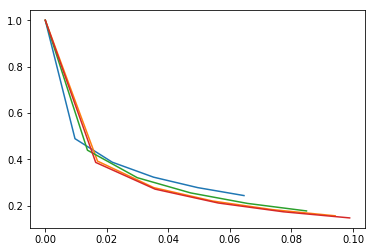

In [13]:
plt.plot(rate_MLSTC.T,dist_MLSTC_test.T)
plt.plot(rate_STNetRandom.T,dist_STNetRandom_test.T)
plt.plot(rate_STNetMLSTC.T,dist_STNetMLSTC_test.T)
plt.plot(rate_STNetProcrustean.T,dist_STNetProcrustean_test.T)